<a href="https://colab.research.google.com/github/yuichielectric/HandsOnMachineLearning/blob/master/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Project Checklist

1. Frame the problem and look at the big picture.
2. Get the data.
3. Exploer the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
5. Explore many different models and shortlist the best ones.
6. Fine-tune your models and combnie them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.

## テーマ

USの国勢調査のデータから、各地区の地価を予測したい。

### コスト関数

#### RMSE (Root Mean Square Error)

$$
RMSE(X, h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m}(h(x^{(i)}) - y^{(i)} )^2}
$$

ここで
 - $M$はデータセットの数
 - $x^{(i)}$はi個目のインスタンスの全フィーチャーの値ベクトル
 - $y^{(i)}$はそのラベル
 - $X$はデータセットすべてのインスタンスのすべてのフィーチャーを含む行列。
 - $h$はprediction function(also called a _hypothesis_)

RMSEはL2 normとも呼ばれる。

#### MAE (Mean Absolute Error)

通常はRMSEを使うが外れ値が多い場合は以下のMAEを使ったほうが良い。

$$
MAE(X, h) = \frac{1}{m} \sum_{i=1}^{m} |h(x^{(i)}) - y^{(i)}|
$$

MAEはL1 normとも呼ばれる。

In [0]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [0]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


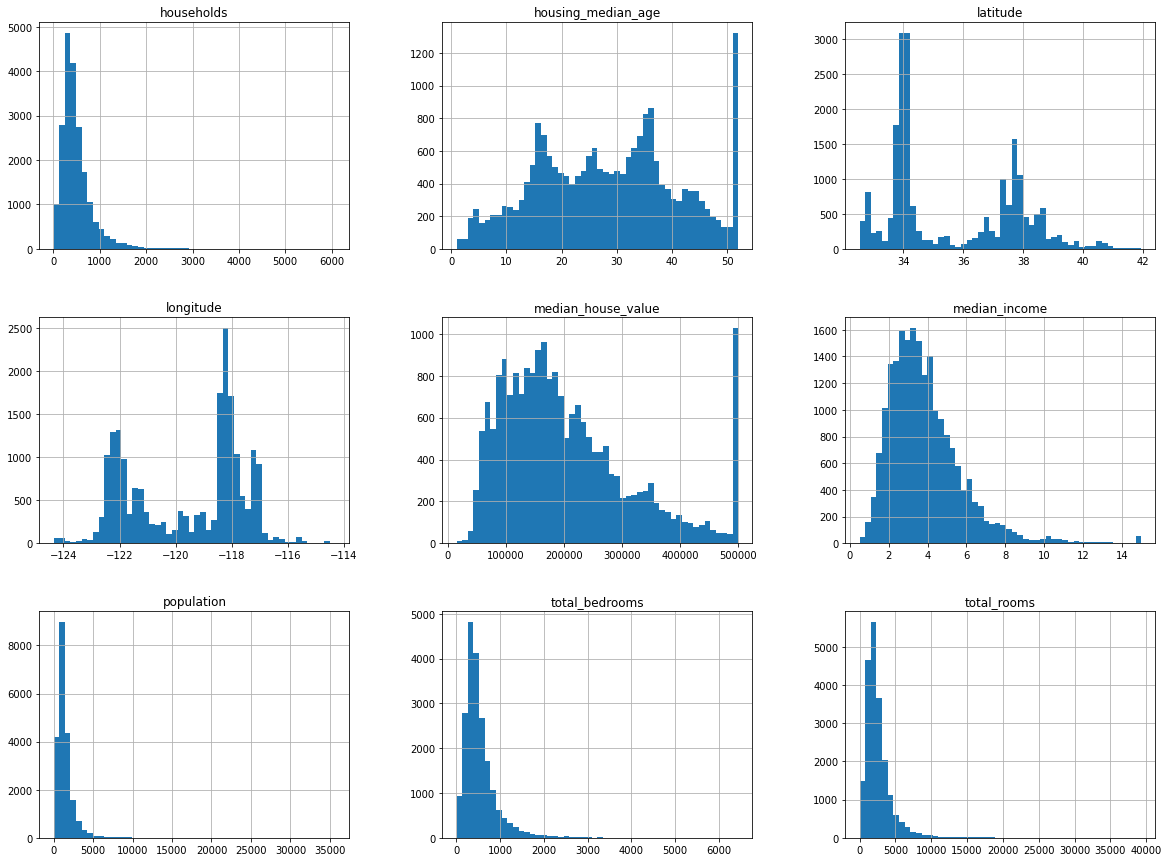

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

テストセットを取得しておく。

In [0]:
import numpy as np

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

ランダムにテストセットを分割すると分割のたびに内容が変化してしまう。これを防ぐために、各データのIDのハッシュ値を計算して、そのハッシュ値をもとに振り分けるという手法がある。

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [0]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

ランダムに分割するだけであれば、sklearn.model_selection.train_test_splitを使える。これはsplit_train_testsとほぼ同じ事を行う。

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
len(train_set)

16512

In [16]:
len(test_set)

4128

データ量が多い場合はランダムに分割しても問題にならないが、今回のようにデータ量が多くない場合はサンプリングバイアスが入り込んでしまう可能性がある。

例えば、地価を予測するのに住人の収入が重要な特徴になり得ると考えている場合、収入の分布を保持したままテストセットを分割する必要がある。そうすることで、サンプリングバイアスが入り込まないようにすることができる。

ただ、収入のデータは実数なので、まずカテゴリ分けをして、その後にカテゴリごとの分布を保持したままテストセットを分割する。この手法を「層化抽出法(stratified sampling)」と呼び、各サブグループを「層(strata)」と呼ぶ。

In [0]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

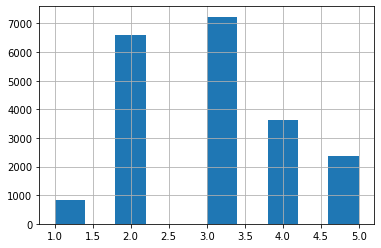

In [18]:
housing["income_cat"].hist()

層化抽出法を行うには、sklearnのStratifiedShuffleSplitを使うことができる。

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [20]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [21]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [0]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

テストセットの分割ができたので、ここからはトレーニングセットの中身をより詳細に見ていく。ここで大事なのは、あくまでもトレーニングセットの中を見るということ。テストセットの中も見てしまうとバイアスが入ってしまうのでだめ。

In [0]:
housing = strat_train_set.copy()

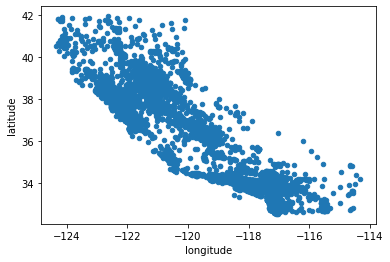

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude")

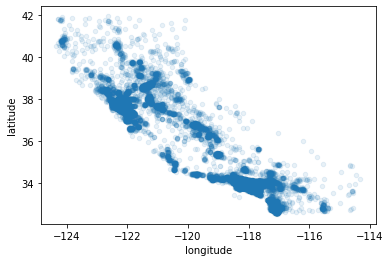

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

各円が人口、色が地価を表すようにプロットしてみる。

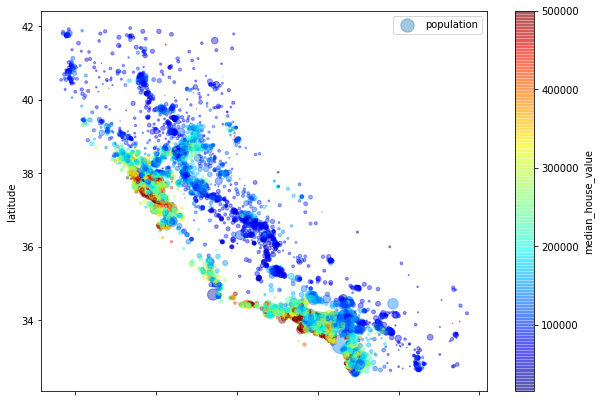

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

上図を見ると、海に近いかどうかと人口密度が地価に関係していそうに見える。そこで属性同士の相関係数(standard correlation coefficient, Pearson's r)を計算してみて、実際にどの属性が地価に関係しているのかを確認する。

ここで注意が必要なのは、相関係数はあくまでも属性同士が線形の関係があるかどうかを表していて、ノンリニアな相関は測れないという点。

In [0]:
corr_matrix = housing.corr()

In [28]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f446a96b358>,
      dtype=object)

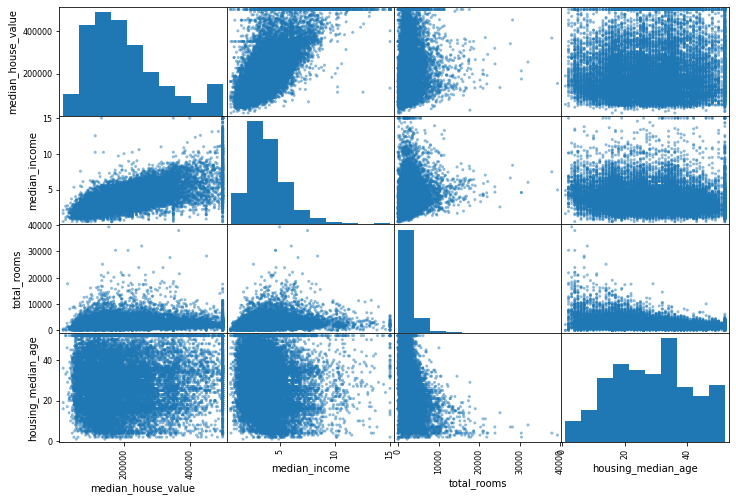

In [29]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

median_house_valueを予測するのに一番使えそうなのはmedian_incomeのようなので、それらだけをプロットしてみる。

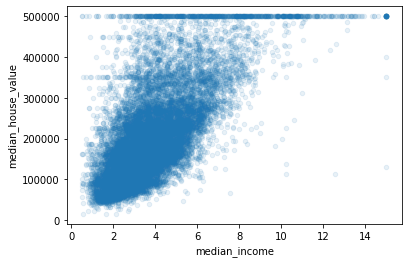

In [30]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

これを見ると、median_house_valueの値が500,000、450,000、350,000、280,000のあたりに線が入っている。これはおそらく、元データの中で家の値段のデータに上限を設定していて、その値を超えたものに関してはすべて同じ値にする、といった処理が行われているんじゃないかと予想できる。

そのデータの量が多いようであれば、それらのデータを取り除く処理を行ったほうが良い。その場合は、テストデータからも取り除く。

ここからは機械学習する前のデータの準備をしていく。例えば、total_roomsやtotal_bedroomsという属性があるが、これらは一軒ごとの値じゃないと意味をなさないので、これらをもとに別の属性を作りだす、といった処理。

In [0]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [0]:
corr_matrix = housing.corr()

In [33]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

ここからデータの準備を始める。まずはデータを元通りに戻す所から。

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

欠損値のある属性に対処する。選択肢は以下の3つ。

1. 欠損値を持つデータを削除する
2. 欠損値を持つ属性を削除する
3. 欠損値を何らかの値で埋める

今回は3で行く。

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [36]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [0]:
X = imputer.transform(housing_num)

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

多くの機械学習アルゴリズムはテキストより数値の方が扱いやすいので、テキスト型の属性を数値に置き換える。ocean_proximityはカテゴリデータなのでこれが可能。

In [40]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [41]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [42]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

このように表現すると一つ問題が起きる。それは、機械学習のアルゴリズムでは、割り当てられた数値が近いということはそれらのカテゴリは似ているということを前提としている。今回のケースではそれは当てはまらないので、一つのカテゴリにまとめるのではなく、カテゴリの値ごとに属性を増やしてそのうちの一つだけに1を割り当て、残りの属性には0を割り当てるようにする。これをone-host encodingと呼ぶ。

In [43]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

one-hot encodingをするとほとんどのカラムは値が0になるので、OneHotEncoderはNumPy arrayを返すのではなく、SciPyのsparse matrixを返す。sparse matrixは0でない値の場所を記録するだけなのでメモリ効率が良い。

In [44]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

自分でScikitLearnのtransformerを作ることもできる。クラスを定義して、fit(), transform(), fit_transform()のメソッドを実装すればduck typingでtransformerと判断してくれる。

その際、TransformerMixinをincludeするとfit_tranformメソッドを実装してくれる。更に、BaseEstimatorを継承するとget_params()とset_params()というhyperparameterチューニングの際に役に立つメソッドも実装してくれる。

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [46]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

transformerの中で最も大事なものがfeature scaling。ほとんどの機械学習アルゴリズムは数値型の属性のスケールがバラバラだとうまく学習することができない。なので、属性のスケールを揃える必要がある。それがfeature scaling。

よく使われるfeature scalingの手法には以下の2つがある。

#### min-max scaling

normalizationとも呼ばれる。値が0から1に収まるように変換する。具体的には、各値から最小値を引き、最大値-最小値で割る。

#### standardization

各値から平均値を引き（全体の平均値が0になるようにする）、標準偏差で割る。こうすることで、0から1には収まらなくなるが、外れ値の影響を受けづらくなる。


改めて大事なことは、どうスケールさせるかはあくまでもトレーニングセットを使って決める。テストセットは含めてはいけない。

ここまで見てきたように、データの前準備には複数のtransformerを正しい順番で適用する必要がある。そのために使えるのが、ScikitLearnが提供するPipelineクラス。

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

ただ、これだと数値属性とカテゴリ属性を別々にtransformする必要があって面倒。そういう時に使えるのがColumnTransformer。

In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

上記のようにnum_pipelineはNumPy matrixを返して、OneHotEncoderはsparse matrixを返すような場合、ColumnTransformerは結果の行列の密度を推測して、適切なmatrixを返してくれる。

データの前準備ができたので、トレーニングを行う。

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [51]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


予測はできるようになったが、精度が悪そう。RMSEを計算してみる。

In [52]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

median_housing_valuesの値が$120,000 - $265,000なので、予測エラーが$68,628は大きすぎる。原因としては、データが少なすぎるか、データに予測に使える特徴が含まれていないか、モデルが弱いか。

まずはもっと複雑なモデルを試してみよう。

In [54]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [56]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

今度はoverfittingしちゃっていそう。それを確かめるために、トレーニングデータからバリデーションセットを切り出そう。ScikitLearnのcross_val_scoreは指定した回数、トレーニングデータからバリデーションセットを切り出してスコアを計算するというクロスバリデーションを行ってくれる。

何度もトレーニングするので、トレーニングに時間がかかるケースではクロスバリデーションのコストが高くなってしまって現実的ではないが、今回のデータ量であれば十分可能。

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [0]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

In [60]:
display_scores(tree_rmse_scores)

Scores: [69860.27722921 67825.12457974 70695.4568145  68775.94556138
 71278.45026627 75480.16191801 70624.37729797 71358.91499516
 76142.69728217 70260.23485055]
Mean: 71230.16407949907
Standard deviation: 2515.9908019316163


これを見る限りDecision TreeはLinear Regressionよりも精度が低そう。Linear Regressionの方もクロスバリデーションしてみる。

In [61]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


やはりLinearRegressionの方がスコアが良い。次にRandomForestRegressorを試してみる。

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49332.71125868 47865.73033481 49797.2952903  51999.83820755
 49496.01568584 53155.31905686 48929.52564814 47817.92069075
 53089.54722379 50052.44937687]
Mean: 50153.63527735869
Standard deviation: 1856.616877919349


#### TIP

複数のモデルを試してそれらを比較するには、パラメータやクロスバリデーションのスコアなどを保存しておく必要がある。その場合、Pythonのpickleモジュールかjoblibライブラリを使うのが良い。

hyperparameterのチューニングをする場合、ScikitLearnのGridSearchCVを使うとチューニングしたいhyperparameterを指定すれば最も良いスコアを出す組み合わせをクロスバリデーションを行って見つけ出してくれる。

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [64]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [65]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63583.935034002076 {'max_features': 2, 'n_estimators': 3}
54647.531179179685 {'max_features': 2, 'n_estimators': 10}
52801.23289800652 {'max_features': 2, 'n_estimators': 30}
60754.943336382355 {'max_features': 4, 'n_estimators': 3}
52717.914602100755 {'max_features': 4, 'n_estimators': 10}
51008.746241861525 {'max_features': 4, 'n_estimators': 30}
58765.77708783922 {'max_features': 6, 'n_estimators': 3}
52014.100892072915 {'max_features': 6, 'n_estimators': 10}
50074.405443208896 {'max_features': 6, 'n_estimators': 30}
59088.449006623945 {'max_features': 8, 'n_estimators': 3}
52033.18701981108 {'max_features': 8, 'n_estimators': 10}
50147.12082070624 {'max_features': 8, 'n_estimators': 30}
62828.91835252111 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54028.881989707486 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59919.12726071239 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52773.20154805585 {'bootstrap': False, 'max_features': 3, 'n_estima